In [ ]:
import pandas as pd, numpy as np, os, time
import torch, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from glob import glob
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset

file_train = 'data/train_imputed.csv'
file_test = 'data/validation_imputed.csv'

from google.colab import drive
drive.mount('/content/drive')
os.chdir('drive/MyDrive/CS/ML/ML-project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Global variables
file_train = 'data/train_imputed.csv'
file_test = 'data/validation_imputed.csv'
var_y='no2'
var_time='time'

# Data functions

In [ ]:
# Categorize available columns in dataset
cols=['time', 'o3', 'wind', 'temp', 'no2', 'no', 'nox', 'year',
      'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
      'day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed',
      'week_1', 'week_10', 'week_11', 'week_12', 'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18', 'week_19', 'week_2', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_3', 'week_30', 'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36', 'week_37', 'week_38', 'week_39', 'week_4', 'week_40', 'week_41', 'week_42', 'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48', 'week_49', 'week_5', 'week_50', 'week_51', 'week_52', 'week_53', 'week_6', 'week_7', 'week_8', 'week_9',
      'day_1', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_2', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_3', 'day_30', 'day_31', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9',
      'hr_0', 'hr_1', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_2', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9',
      'hday_lundi_de_pâques', 'hday_fête_du_travail', 'hday_fête_de_la_victoire', 'hday_ascension', 'hday_lundi_de_pentecôte', 'hday_fête_nationale', 'hday_assomption', 'hday_toussaint', 'hday_armistice', 'hday_noël', 'hday_jour_de_l_an',
      'hday', 'hday_after1', 'hday_before1']

cols_weather=['wind', 'temp']
cols_hday=['hday', 'hday_after1', 'hday_before1']
cols_specific_hday=[i for i in cols if i.startswith('hday_') and i not in ['hday_after1','hday_before1']]
cols_month=[i for i in cols if i.startswith('month_')]
cols_weekday=['day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed']
cols_day=[i for i in cols if i.startswith('day_') and i not in cols_weekday]
cols_week=[i for i in cols if i.startswith('week_')]
cols_hour=[i for i in cols if i.startswith('hr_')]

In [ ]:
def get_lookback(file, lookback_dict):
    data=pd.read_csv(file,parse_dates=[var_time])

    keepcols=[var_time,var_y]
    for key in lookback_dict.keys():
        if lookback_dict[key]>0:
            for i in range(1,lookback_dict[key]+1):
                data[f'{key}_{i}']=data[key].shift(i)
                keepcols.append(f'{key}_{i}')
        else:
            keepcols.append(key)

    # Subset original data
    data=data.loc[max(lookback_dict.values()):,keepcols].set_index(var_time)

    return data

def normalize_to_tensor(train, test):
    xcols=[i for i in train.columns if i!=var_y]
    scalerx = MinMaxScaler(feature_range=(0,1))
    scalery = MinMaxScaler(feature_range=(0,1))

    scaled_trainx = scalerx.fit_transform(train[xcols].values.astype('float32'))
    scaled_testx = scalerx.transform(test[xcols].values.astype('float32'))

    scaled_trainy = scalery.fit_transform(train[[var_y]].values.astype('float32'))
    scaled_testy = scalery.transform(test[[var_y]].values.astype('float32'))

    X_train, y_train = torch.tensor(scaled_trainx).unsqueeze(1), torch.tensor(scaled_trainy).unsqueeze(1)
    X_test, y_test = torch.tensor(scaled_testx).unsqueeze(1), torch.tensor(scaled_testy).unsqueeze(1)
    print('Train:\t',X_train.shape,'\t', y_train.shape)
    print('Test:\t',X_test.shape,'\t', y_test.shape)

    return scalerx, scalery, X_train, y_train, X_test, y_test

def get_data(file_train,file_test, lookback_dict):
    train=get_lookback(file=file_train, lookback_dict=lookback_dict)
    test=get_lookback(file=file_test, lookback_dict=lookback_dict)
    scalerx, scalery, X_train, y_train, X_test, y_test = normalize_to_tensor(train, test)
    return train, test, scalerx, scalery, X_train, y_train, X_test, y_test

# Model functions and classes

In [ ]:
class AirModelDrop(nn.Module):
    """
    Add dropout (or none if prob is 0) after every RNN layer
    """
    def __init__(self, input_size, hidden_nodes, num_layers, dropout_prob):
        super().__init__()
        self.rnn1 = nn.RNN(input_size=input_size, hidden_size=hidden_nodes, num_layers=num_layers, batch_first=True, dropout=dropout_prob)
        self.linear = nn.Linear(hidden_nodes, 1)

    def forward(self, x):
        x, _ = self.rnn1(x)
        x = self.linear(x)
        return x

class AirModelDropOnce(nn.Module):
    """
    Add dropout only after the first RNN layer
    """
    def __init__(self, input_size, hidden_nodes, num_layers, dropout_prob):
        super().__init__()

        # Initial RNN layer
        self.initial_rnn = nn.RNN(input_size=input_size, hidden_size=hidden_nodes, num_layers=1, batch_first=True) # Set to 1 for the first layer

        # Dropout layer after the initial RNN layer
        self.dropout = nn.Dropout(p=dropout_prob)

        # Multiple RNN layers # Input size should match the hidden size of the previous layer
        self.middle_rnns = nn.ModuleList([
            nn.RNN(input_size=hidden_nodes, hidden_size=hidden_nodes, batch_first=True)
            for _ in range(num_layers - 1)  # Subsequent RNN layers
        ])

        # Output layer
        self.output_layer = nn.Linear(hidden_nodes, 1)

    def forward(self, x):
        x, _ = self.initial_rnn(x)
        x = self.dropout(x)

        # Multiple RNN layers
        for rnn_layer in self.middle_rnns:
            x, _ = rnn_layer(x)
        x = self.output_layer(x)
        return x

class AirModelDropBN(nn.Module):
    """
    Add batch normalization after the first RNN layer then dropout after every RNN layer after that
    """
    def __init__(self, input_size, hidden_nodes, num_layers, dropout_prob):
        super().__init__()
        self.rnn1 = nn.RNN(input_size=input_size, hidden_size=hidden_nodes, num_layers=1, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_nodes)
        self.rnn2 = nn.RNN(input_size=hidden_nodes, hidden_size=hidden_nodes, num_layers=num_layers-1, batch_first=True, dropout=dropout_prob)
        self.linear = nn.Linear(hidden_nodes, 1)
    def forward(self, x):
        x, _ = self.rnn1(x)
        x = self.bn(x)
        x, _ = self.rnn2(x)
        x = self.linear(x)
        return x

In [ ]:
def plot_results(stats, test, pred_test):
    # Calculate RMSE
    rmse_test = np.sqrt(((test[var_y] - pred_test[:, 0]) ** 2).mean())

    # Define subplot widths
    width_ratios = [17, 6, 6]

    # Plotting predicted vs actual values in one subplot
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(29,5), gridspec_kw={'width_ratios': width_ratios})

    # Subplot 1: Predicted vs Actual Values Over Time
    axs[0].plot(test.index, test[var_y], label='Test Actual', color='b')
    axs[0].plot(test.index, pred_test[:, 0], label='Predicted', color='r', alpha=0.7)
    axs[0].set_title('Predicted vs Actual Values Over Time')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Values')
    axs[0].legend()

    # Subplot 2: Train and Test RMSE
    axs[1].plot(stats.epoch, stats.train_rmse, 'bo-', label='Train RMSE')  # 'o-' indicates blue circles connected with lines
    axs[1].plot(stats.epoch, stats.test_rmse, 'ro-', label='Test RMSE')    # 'o-' indicates red circles connected with lines
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('RMSE')
    axs[1].legend()

    # Subplot 3: Train and Test Loss RMSE
    axs[2].plot(stats.epoch, stats.train_loss_rmse, 'bo-', label='Train Loss RMSE')  # 'o-' indicates blue circles connected with lines
    axs[2].plot(stats.epoch, stats.test_loss_rmse, 'ro-', label='Test Loss RMSE')    # 'o-' indicates red circles connected with lines
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Loss RMSE')
    axs[2].legend()

    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()
    plt.close()

    # Display RMSE
    print(f'RMSE on Test Set: {rmse_test:.4f}')


In [ ]:
def save_airmodel(model, epoch, optimizer, loss, PATH):
  """
  Save pytorch model checkpoint
  """
  torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss
              }, PATH)

def load_airmodel(model, optimizer,PATH):
  """
  Use after initializing model and optimizer
    model = TheModelClass(*args, **kwargs)
    optimizer = TheOptimizerClass(*args, **kwargs)

  """
  checkpoint = torch.load(PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']

  return model, optimizer, epoch, loss

In [ ]:
def train_rnn(X_train, y_train,
              X_test, y_test,
              scalery,
              model_type,
              input_size, hidden_nodes, num_layers,
              lr=1e-3,
              dropout_prob=0,
              n_epochs=10,
              out_every=2,
              batch_size=8,
              var_y=var_y,
              savemodel=False,
              suffix=None
              ):
    if model_type=='dropout':
        model=AirModelDrop(input_size, hidden_nodes, num_layers, dropout_prob)
    elif model_type=='dropout-once':
        model=AirModelDropOnce(input_size, hidden_nodes, num_layers, dropout_prob)
    elif model_type=='with-bn':
        model=AirModelDropBN(input_size, hidden_nodes, num_layers, dropout_prob)

    start_time = time.time()

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)

    epochs=[]
    stats_train=[]
    stats_test=[]
    stats_train_loss=[]
    stats_test_loss=[]

    for epoch in range(1,n_epochs+1):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        if (epoch % out_every != 0) and epoch!=1:
            continue
        model.eval()

        with torch.no_grad():
            # denormalized
            pred_train = scalery.inverse_transform(model(X_train)[:, -1, :])
            pred_test = scalery.inverse_transform(model(X_test)[:, -1, :])

            rmse_train = np.sqrt(((train[var_y] - pred_train[:, 0]) ** 2).mean())
            rmse_test = np.sqrt(((test[var_y] - pred_test[:, 0]) ** 2).mean())

            epochs.append(epoch)
            stats_test.append(rmse_test)
            stats_train.append(rmse_train)

            # statistics on normalized data
            y_pred = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_test)
            test_rmse = np.sqrt(loss_fn(y_pred, y_test))

            stats_train_loss.append(train_rmse)
            stats_test_loss.append(test_rmse)

            print("Epoch %d \t|| train RMSE %.4f, test RMSE %.4f || train loss RMSE %.4f, test loss RMSE %.4f" % (
                epoch, rmse_train, rmse_test, train_rmse, test_rmse))
    elapsed_time = time.time() - start_time

    stats=pd.DataFrame(zip(epochs, stats_train, stats_test, stats_train_loss, stats_test_loss), columns=['epoch', 'train_rmse', 'test_rmse', 'train_loss_rmse', 'test_loss_rmse']).astype(float)
    plot_results(stats, test, pred_test)

    if savemodel and suffix:
        save_airmodel(model, epoch, optimizer, loss, PATH=f'models/rnn_{suffix}.tar')

    return model, stats, elapsed_time

# UNIVARIATE Execution

## Try with many epochs (200)
To justify only using 10 epochs, 1 hour lookback, 1 layer, no dropout

In [ ]:
# DATA
lookback_dict={**{'no2':1}}

train, test, scalerx, scalery, X_train, y_train, X_test, y_test = get_data(file_train,file_test, lookback_dict)

Train:	 torch.Size([17519, 1, 1]) 	 torch.Size([17519, 1, 1])
Test:	 torch.Size([4415, 1, 1]) 	 torch.Size([4415, 1, 1])


Epoch 1 	|| train RMSE 6.3596, test RMSE 6.5091 || train loss RMSE 0.0517, test loss RMSE 0.0530
Epoch 10 	|| train RMSE 6.4241, test RMSE 6.6241 || train loss RMSE 0.0523, test loss RMSE 0.0539
Epoch 20 	|| train RMSE 6.3253, test RMSE 6.5090 || train loss RMSE 0.0515, test loss RMSE 0.0530
Epoch 30 	|| train RMSE 6.5346, test RMSE 6.8774 || train loss RMSE 0.0532, test loss RMSE 0.0560
Epoch 40 	|| train RMSE 6.3071, test RMSE 6.5266 || train loss RMSE 0.0513, test loss RMSE 0.0531
Epoch 50 	|| train RMSE 6.3327, test RMSE 6.6071 || train loss RMSE 0.0515, test loss RMSE 0.0538
Epoch 60 	|| train RMSE 6.3194, test RMSE 6.5800 || train loss RMSE 0.0514, test loss RMSE 0.0535
Epoch 70 	|| train RMSE 6.3062, test RMSE 6.5803 || train loss RMSE 0.0513, test loss RMSE 0.0535
Epoch 80 	|| train RMSE 6.3307, test RMSE 6.5509 || train loss RMSE 0.0515, test loss RMSE 0.0533
Epoch 90 	|| train RMSE 6.3029, test RMSE 6.5909 || train loss RMSE 0.0513, test loss RMSE 0.0536
Epoch 100 	|| train R

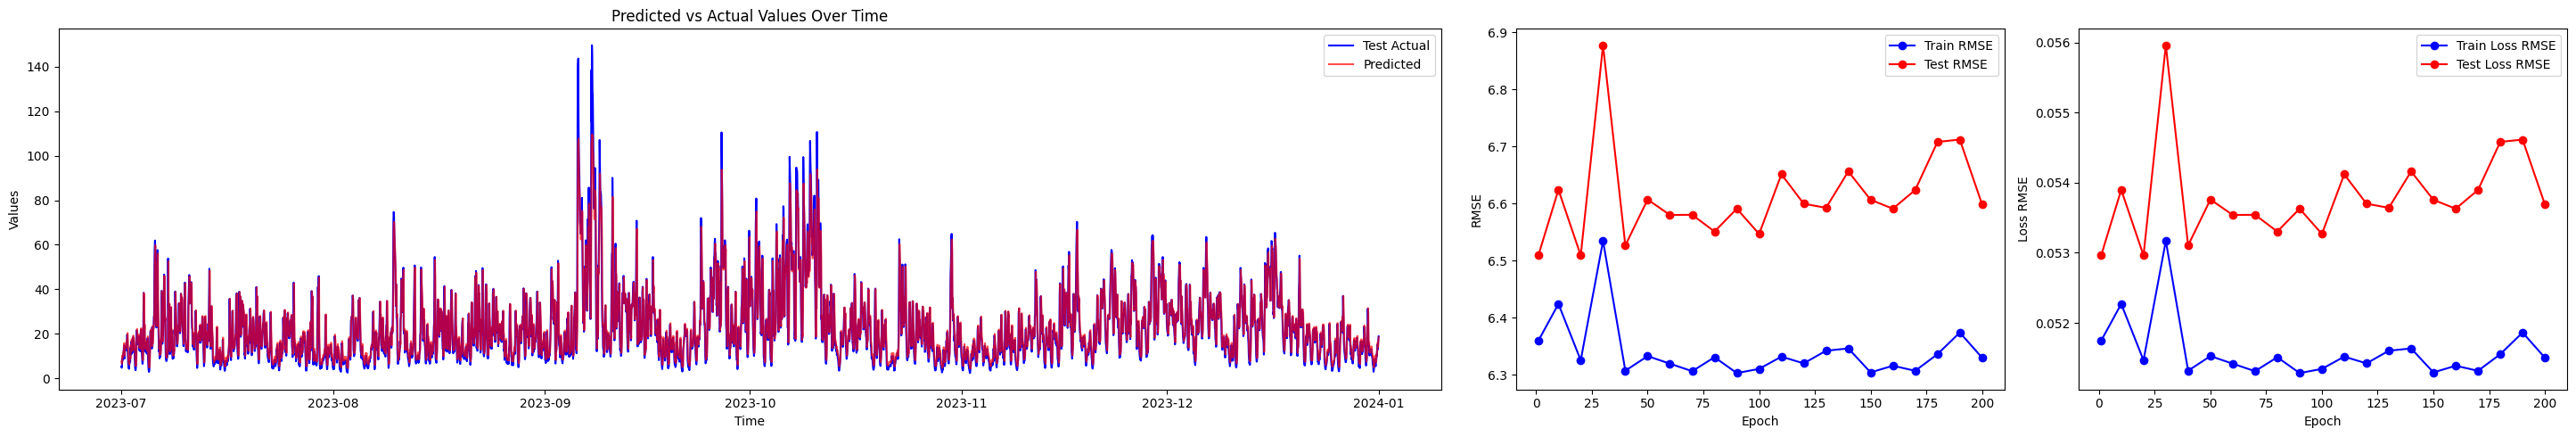

RMSE on Test Set: 6.5984
took 10.44 minutes


In [ ]:
# Set a seed for reproducibility
torch.manual_seed(42)

# Fixed
input_size = int(X_train.size()[-1])
hidden_nodes = 50
out_every = 10
batch_size = 8
n_epochs = 200
lr=1e-3

# Variable
num_layers = 1
dropout_prob = 0
model_type='dropout'

suffix='200-epochs'

m,s,t=train_rnn(X_train, y_train, X_test, y_test, scalery,
              model_type,
              input_size, hidden_nodes, num_layers,
              lr=lr,
              dropout_prob=dropout_prob,
              n_epochs=n_epochs,
              out_every=out_every,
              batch_size=batch_size,
              var_y=var_y,
              savemodel=True,
              suffix=suffix
              )
print(f"took {(t/60):.2f} minutes")
s.to_csv(f'results/rnn_{suffix}.csv', index=False)

## Iterate for different models, dropout percentages, and lookbacks

In [ ]:
suffix='univar_iters_10-epochs'
csv_path=f'results/rnn_{suffix}.csv'
csv_path_time=f'results/rnn_time_{suffix}.csv'

iterators=['lookback','model_type','num_layers','hidden_nodes','batch_size','lr','dropout_prob']

iter_lookback = [1, 12, 24, 72, 168] # actual only 1
iter_model_type = ['dropout', 'dropout-once', 'with-bn'] # actual only dropout
iter_num_layers = [1, 5, 10, 50]
iter_hidden_nodes  = [50, 100]
iter_batch_size = [8, 128]
iter_lr = [0.01, 0.0001]
iter_dropout_prob = [0, 0.2, 0.4, 0.6, 0.8]

# Fixed
out_every = 5
n_epochs = 10

# # Initial saving of csvs
# pd.DataFrame(columns=['epoch', 'train_rmse', 'test_rmse', 'train_loss_rmse', 'test_loss_rmse']+iterators).to_csv(csv_path, index=False) # training/test stats
# pd.DataFrame(columns=iterators+['time']).to_csv(csv_path_time, index=False) # total training time

In [ ]:
# ITERATE THROUGH GRID

# Set a seed for reproducibility
torch.manual_seed(42)

for lookback in iter_lookback:
  # DATA
  lookback_dict={**{'no2':lookback}}
  train, test, scalerx, scalery, X_train, y_train, X_test, y_test = get_data(file_train,file_test, lookback_dict)
  input_size = int(X_train.size()[-1])

  for model_type in iter_model_type:
    for num_layers in iter_num_layers:
      for hidden_nodes in iter_hidden_nodes:
        for batch_size in iter_batch_size:
          for lr in iter_lr:
            for dropout_prob in iter_dropout_prob:
              iterators_vals=[lookback,model_type,num_layers,hidden_nodes,batch_size,lr,dropout_prob]

              output_string = "\n=================================="+" || ".join(f"{var_name}={var_value}" for var_name, var_value in zip(iterators, iterators_vals))+"=================================="
              print(output_string)

              # MODEL
              m,s,t=train_rnn(X_train, y_train, X_test, y_test, scalery,
                            model_type,
                            input_size, hidden_nodes, num_layers,
                            dropout_prob=dropout_prob,
                            n_epochs=n_epochs,
                            out_every=out_every,
                            batch_size=batch_size,
                            var_y=var_y,
                            savemodel=False
                            )

              # Update csv
              s.assign(**dict(zip(iterators, iterators_vals))).to_csv(csv_path, mode='a', header=False, index=False)
              pd.DataFrame([iterators_vals + [t]], columns=iterators+['time']).to_csv(csv_path_time, mode='a', header=False, index=False)

              print(f"took {(t/60):.2f} minutes")

Output hidden; open in https://colab.research.google.com to view.

## Determine best hyperparams

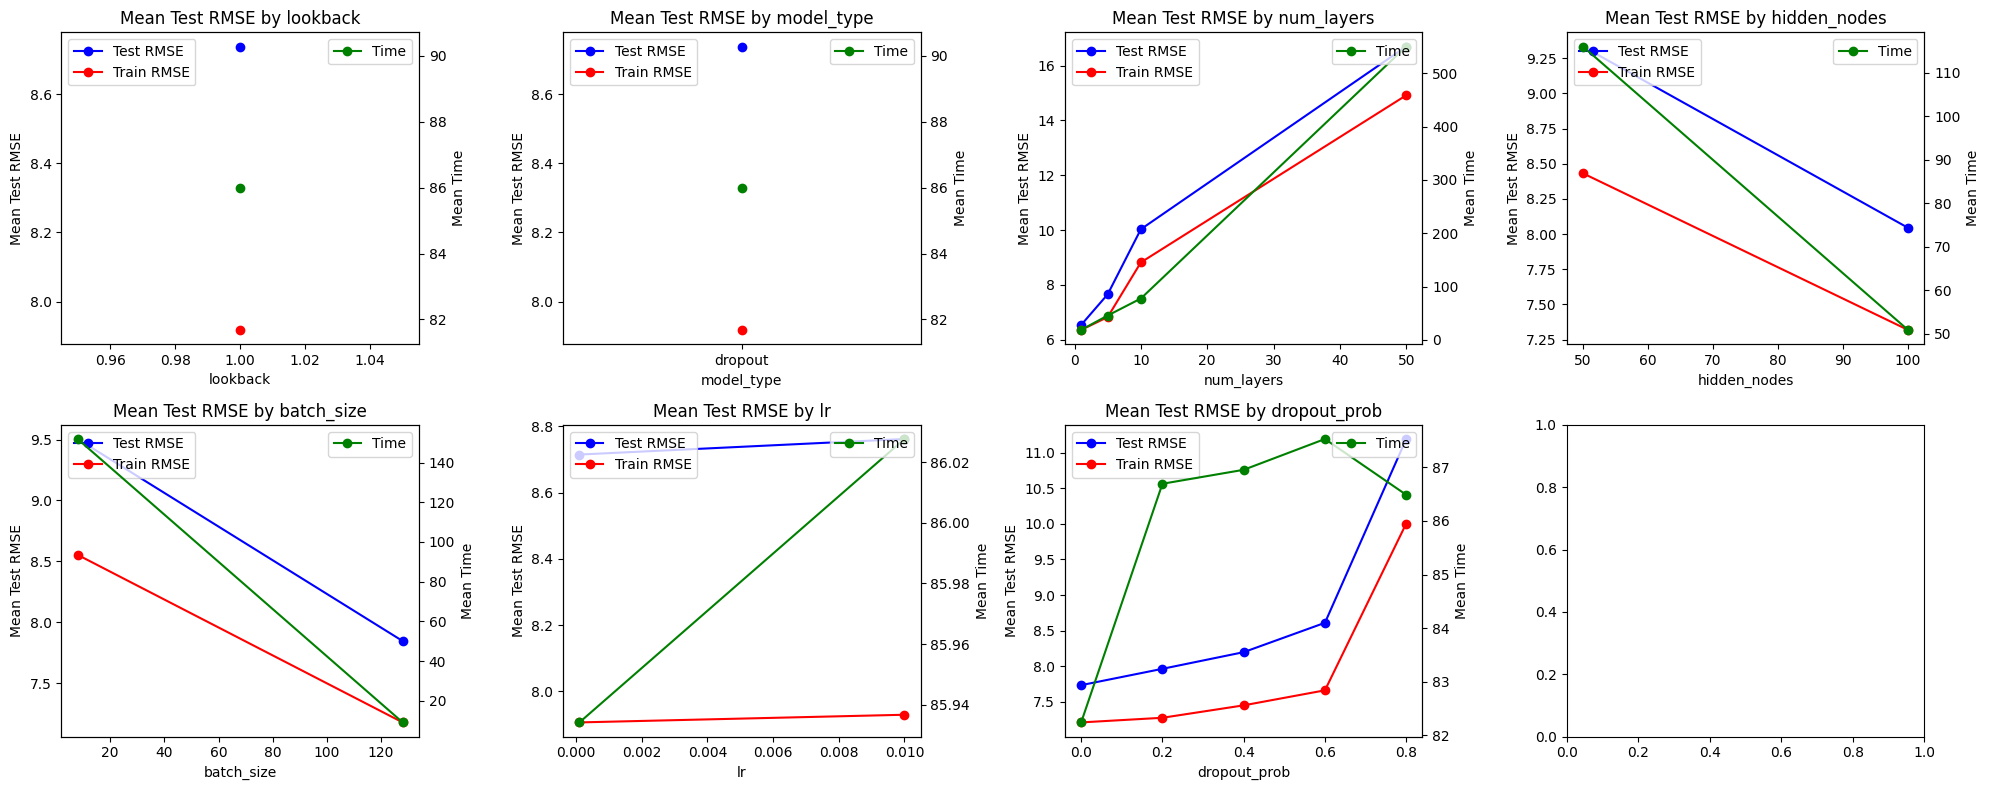

In [ ]:
suffix='univar_iters_10-epochs'
csv_path=f'results/rnn_{suffix}.csv'
csv_path_time=f'results/rnn_time_{suffix}.csv'
check=pd.read_csv(csv_path).query("epoch==10")
check_time=pd.read_csv(csv_path_time)
iterators=['lookback','model_type','num_layers','hidden_nodes','batch_size','lr','dropout_prob']

# Create a grid of subplots
num_plots = len(iterators)
num_cols = 4  # You can adjust the number of columns in the grid
num_rows = -(-num_plots // num_cols)  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4*num_rows))

# Flatten the axes array to make indexing easier
axes = axes.flatten()

# Loop through each variable in `iterators` and plot
for i, var in enumerate(iterators):
    check_grouped_test = check.groupby(var).test_rmse.mean()
    check_grouped_train = check.groupby(var).train_rmse.mean()  # Assuming you have a 'train_rmse' column
    check_grouped_time = check_time.groupby(var).time.mean()  # Assuming you have a 'time' column

    # Plot Test RMSE on the i-th subplot
    axes[i].plot(check_grouped_test,'bo-', label='Test RMSE')
    axes[i].set_title(f'Mean Test RMSE by {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Mean Test RMSE')

    # Plot Train RMSE on the same subplot in red
    axes[i].plot(check_grouped_train, 'ro-', label='Train RMSE')

    # Create a secondary y-axis for time on the right side
    ax_time = axes[i].twinx()

    # Plot Time on the right y-axis in green
    ax_time.plot(check_grouped_time, 'go-', label='Time')
    ax_time.set_ylabel('Mean Time')  # Set label for the right y-axis

    # Add legend
    axes[i].legend(loc='upper left')
    ax_time.legend(loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [ ]:
# plt.scatter(check.batch_size, check.test_rmse, c=check.dropout_prob, cmap='viridis')
# plt.colorbar(label='Number of Layers')
# plt.show()

## Iterate again: Dropout once or every? Lookback.

In [ ]:
suffix='univar_iters_10-epochs-pt2'
csv_path=f'results/rnn_{suffix}.csv'
csv_path_time=f'results/rnn_time_{suffix}.csv'

iterators=['lookback','model_type','num_layers','hidden_nodes','batch_size','lr','dropout_prob']

iter_lookback = [12, 24, 72, 168]
iter_model_type = ['dropout', 'dropout-once']
iter_num_layers = [1, 5]
iter_hidden_nodes  = [100]
iter_batch_size = [128]
iter_lr = [0.0001]
iter_dropout_prob = [0, 0.2, 0.4, 0.6]

# Fixed
out_every = 5
n_epochs = 10

# Initial saving of csvs
pd.DataFrame(columns=['epoch', 'train_rmse', 'test_rmse', 'train_loss_rmse', 'test_loss_rmse']+iterators).to_csv(csv_path, index=False) # training/test stats
pd.DataFrame(columns=iterators+['time']).to_csv(csv_path_time, index=False) # total training time

In [ ]:
# ITERATE THROUGH GRID

# Set a seed for reproducibility
torch.manual_seed(42)

for lookback in iter_lookback:
  # DATA
  lookback_dict={**{'no2':lookback}}
  train, test, scalerx, scalery, X_train, y_train, X_test, y_test = get_data(file_train,file_test, lookback_dict)
  input_size = int(X_train.size()[-1])

  for model_type in iter_model_type:
    for num_layers in iter_num_layers:
      for hidden_nodes in iter_hidden_nodes:
        for batch_size in iter_batch_size:
          for lr in iter_lr:
            for dropout_prob in iter_dropout_prob:
              iterators_vals=[lookback,model_type,num_layers,hidden_nodes,batch_size,lr,dropout_prob]

              output_string = "\n=================================="+" || ".join(f"{var_name}={var_value}" for var_name, var_value in zip(iterators, iterators_vals))+"=================================="
              print(output_string)

              # MODEL
              m,s,t=train_rnn(X_train, y_train, X_test, y_test, scalery,
                            model_type,
                            input_size, hidden_nodes, num_layers,
                            dropout_prob=dropout_prob,
                            n_epochs=n_epochs,
                            out_every=out_every,
                            batch_size=batch_size,
                            var_y=var_y,
                            savemodel=False
                            )

              # Update csv
              s.assign(**dict(zip(iterators, iterators_vals))).to_csv(csv_path, mode='a', header=False, index=False)
              pd.DataFrame([iterators_vals + [t]], columns=iterators+['time']).to_csv(csv_path_time, mode='a', header=False, index=False)

              print(f"took {(t/60):.2f} minutes")

Output hidden; open in https://colab.research.google.com to view.

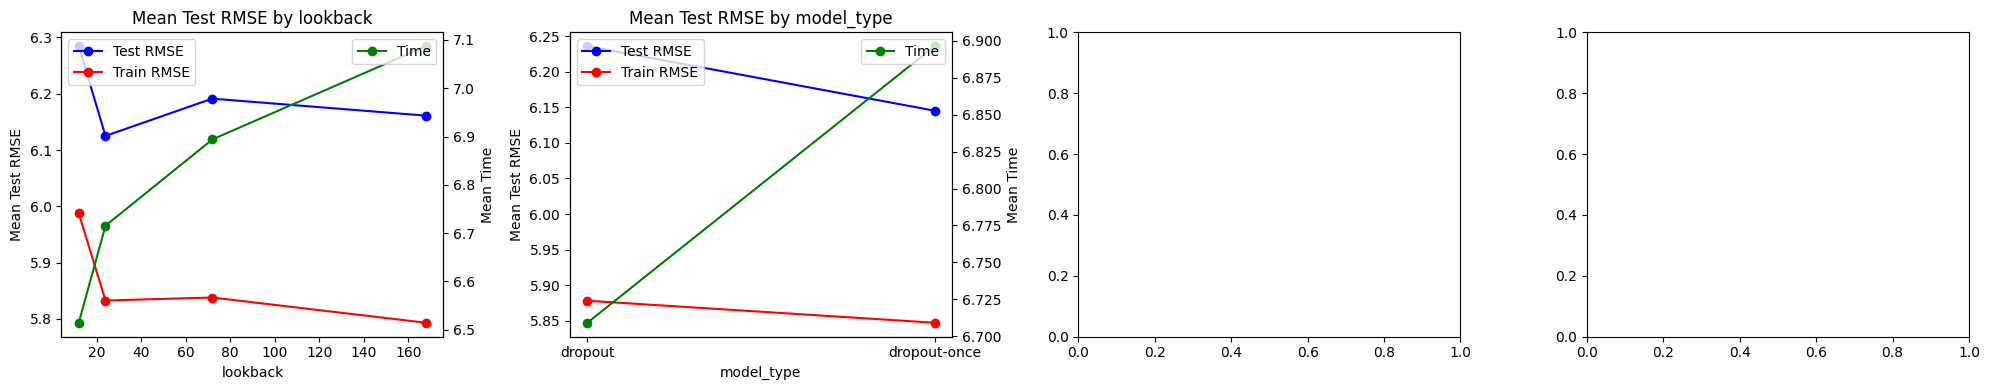

In [ ]:
suffix='univar_iters_10-epochs-pt2'
csv_path=f'results/rnn_{suffix}.csv'
csv_path_time=f'results/rnn_time_{suffix}.csv'
check=pd.read_csv(csv_path).query("epoch==10")
check_time=pd.read_csv(csv_path_time)
iterators=['lookback','model_type']

# Create a grid of subplots
num_plots = len(iterators)
num_cols = 4  # You can adjust the number of columns in the grid
num_rows = -(-num_plots // num_cols)  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4*num_rows))

# Flatten the axes array to make indexing easier
axes = axes.flatten()

# Loop through each variable in `iterators` and plot
for i, var in enumerate(iterators):
    check_grouped_test = check.groupby(var).test_rmse.mean()
    check_grouped_train = check.groupby(var).train_rmse.mean()  # Assuming you have a 'train_rmse' column
    check_grouped_time = check_time.groupby(var).time.mean()  # Assuming you have a 'time' column

    # Plot Test RMSE on the i-th subplot
    axes[i].plot(check_grouped_test,'bo-', label='Test RMSE')
    axes[i].set_title(f'Mean Test RMSE by {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Mean Test RMSE')

    # Plot Train RMSE on the same subplot in red
    axes[i].plot(check_grouped_train, 'ro-', label='Train RMSE')

    # Create a secondary y-axis for time on the right side
    ax_time = axes[i].twinx()

    # Plot Time on the right y-axis in green
    ax_time.plot(check_grouped_time, 'go-', label='Time')
    ax_time.set_ylabel('Mean Time')  # Set label for the right y-axis

    # Add legend
    axes[i].legend(loc='upper left')
    ax_time.legend(loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Best univariate model

In [ ]:
check=pd.concat([pd.read_csv(i) for i in glob('results/rnn_univar*.csv')]).query("epoch==10")
top=check.sort_values(by=['test_rmse']).iloc[0,:]
top

epoch                      10.0
train_rmse             5.568889
test_rmse              5.749493
train_loss_rmse        0.045312
test_loss_rmse         0.046782
lookback                    168
model_type         dropout-once
num_layers                    1
hidden_nodes                100
batch_size                  128
lr                       0.0001
dropout_prob                0.0
Name: 170, dtype: object

In [ ]:
# Define hyperparameters of best model
top_model={'lookback': 168,
          'model_type': 'dropout-once',
          'num_layers': 1,
          'hidden_nodes': 100,
          'batch_size': 128,
          'lr': 0.0001,
          'dropout_prob': 0.0}

# Fixed
out_every = 5
n_epochs = 10

for k in top_model.keys():
  globals()[k]=top_model[k]

<ipython-input-7-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{key}_{i}']=data[key].shift(i)
<ipython-input-7-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{key}_{i}']=data[key].shift(i)
<ipython-input-7-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

Train:	 torch.Size([17352, 1, 168]) 	 torch.Size([17352, 1, 1])
Test:	 torch.Size([4248, 1, 168]) 	 torch.Size([4248, 1, 1])
Epoch 1 	|| train RMSE 7.0339, test RMSE 7.2566 || train loss RMSE 0.0572, test loss RMSE 0.0590
Epoch 5 	|| train RMSE 5.7166, test RMSE 5.9305 || train loss RMSE 0.0465, test loss RMSE 0.0483
Epoch 10 	|| train RMSE 5.5844, test RMSE 5.8122 || train loss RMSE 0.0454, test loss RMSE 0.0473


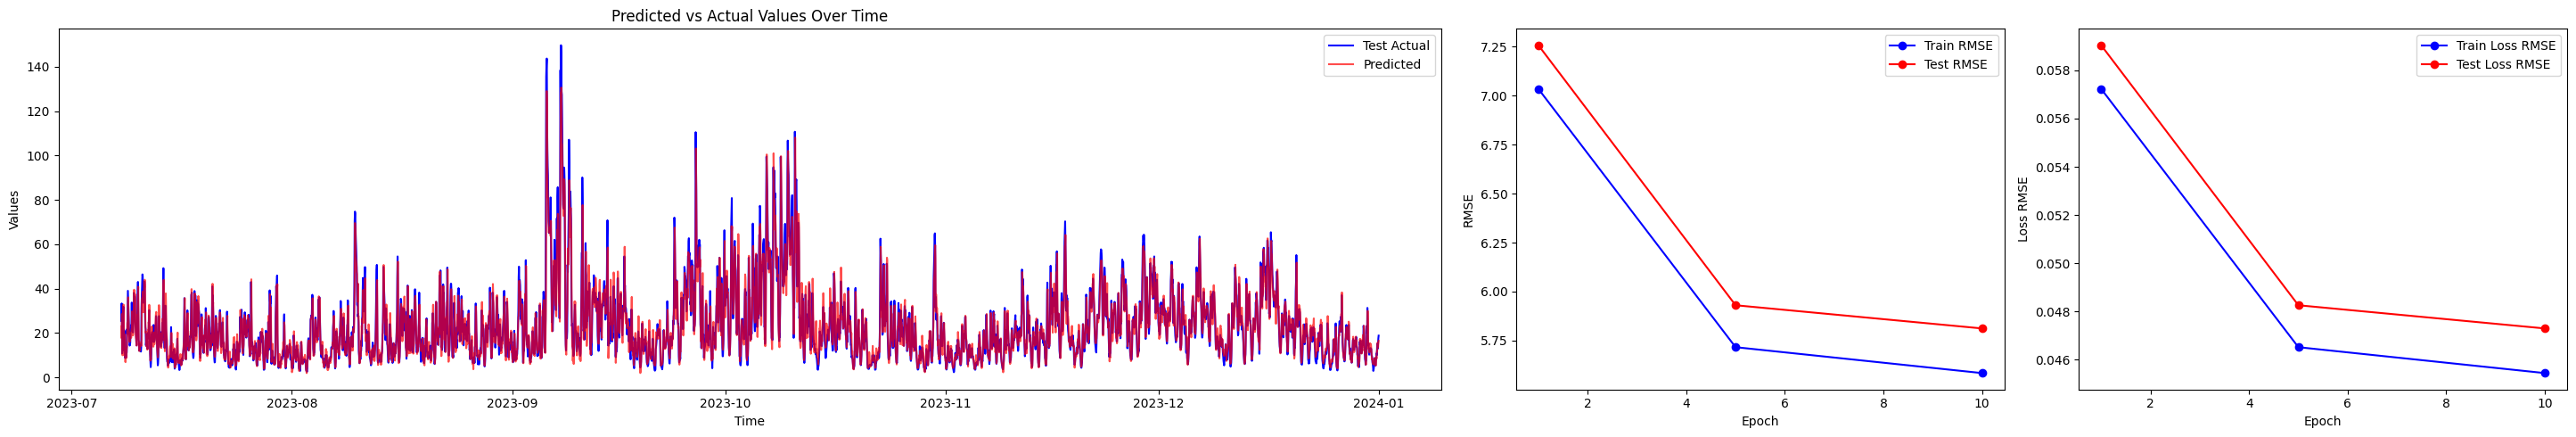

RMSE on Test Set: 5.8122


In [ ]:
# Set a seed for reproducibility
torch.manual_seed(42)

lookback_dict={**{'no2':lookback}}
train, test, scalerx, scalery, X_train, y_train, X_test, y_test = get_data(file_train,file_test, lookback_dict)
input_size = int(X_train.size()[-1])

m,s,t=train_rnn(X_train, y_train, X_test, y_test, scalery,
                            model_type,
                            input_size, hidden_nodes, num_layers,
                            dropout_prob=dropout_prob,
                            n_epochs=n_epochs,
                            out_every=out_every,
                            batch_size=batch_size,
                            var_y=var_y,
                            savemodel=True,
                suffix='univar-best-model'
                            )

## Add batch normalization (output in another notebook)

In [ ]:
file_train = 'data/train_imputed.csv'
file_test = 'data/validation_imputed.csv'

# Define hyperparameters of best model
top_model={'lookback': 168,
          'model_type': 'with-bn',
          'num_layers': 1,
          'hidden_nodes': 100,
          'batch_size': ,#128,
          'lr': 0.0001,
          'dropout_prob': 0.0}

# Fixed
out_every = 5
n_epochs = 10

for k in top_model.keys():
  globals()[k]=top_model[k]

In [ ]:
# Set a seed for reproducibility
torch.manual_seed(42)

lookback_dict={**{'no2':lookback}}
train, test, scalerx, scalery, X_train, y_train, X_test, y_test = get_data(file_train,file_test, lookback_dict)
input_size = int(X_train.size()[-1])

m,s,t=train_rnn(X_train, y_train, X_test, y_test, scalery,
                            model_type,
                            input_size, hidden_nodes, num_layers,
                            dropout_prob=dropout_prob,
                            n_epochs=n_epochs,
                            out_every=out_every,
                            batch_size=batch_size,
                            var_y=var_y,
                            savemodel=False#,
                # suffix='univar-best-model'
                            )

Train:	 torch.Size([17519, 1, 1]) 	 torch.Size([17519, 1, 1])
Test:	 torch.Size([4415, 1, 1]) 	 torch.Size([4415, 1, 1])


IndexError: list index out of range

# MULTIVARIATE - build on best univariate model

In [ ]:
# Define hyperparameters of best model
top_model={'lookback': 168,
          'model_type': 'dropout-once',
          'num_layers': 1,
          'hidden_nodes': 100,
          'batch_size': 128,
          'lr': 0.0001,
          'dropout_prob': 0.0}

# Fixed
out_every = 5
n_epochs = 10

for k in top_model.keys():
  globals()[k]=top_model[k]

## Weather

<ipython-input-7-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{key}_{i}']=data[key].shift(i)
<ipython-input-7-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{key}_{i}']=data[key].shift(i)
<ipython-input-7-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

Train:	 torch.Size([17352, 1, 170]) 	 torch.Size([17352, 1, 1])
Test:	 torch.Size([4248, 1, 170]) 	 torch.Size([4248, 1, 1])
Epoch 1 	|| train RMSE 8.3805, test RMSE 8.7571 || train loss RMSE 0.0682, test loss RMSE 0.0713
Epoch 5 	|| train RMSE 5.8615, test RMSE 6.1547 || train loss RMSE 0.0477, test loss RMSE 0.0501
Epoch 10 	|| train RMSE 5.6434, test RMSE 5.8798 || train loss RMSE 0.0459, test loss RMSE 0.0478


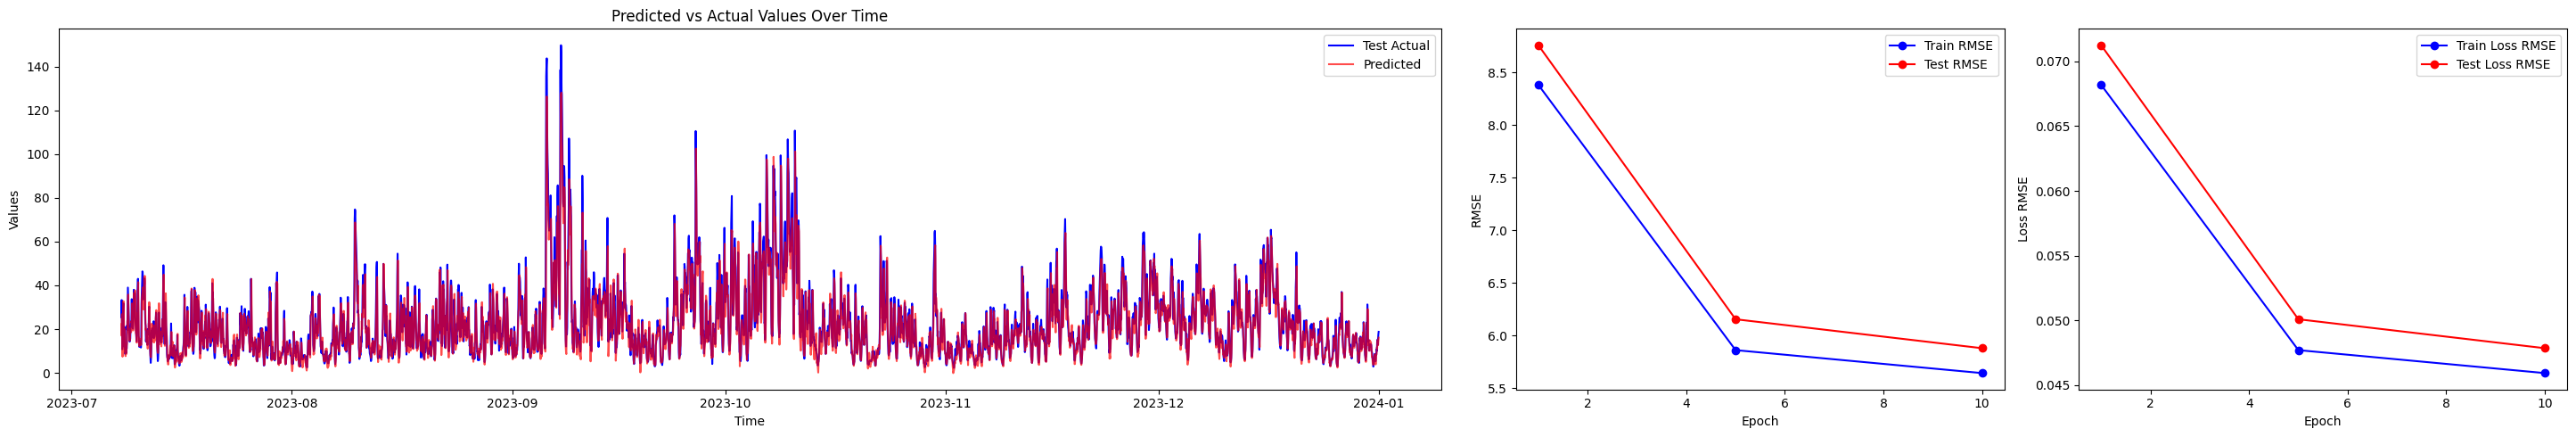

RMSE on Test Set: 5.8798


<ipython-input-7-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{key}_{i}']=data[key].shift(i)
<ipython-input-7-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{key}_{i}']=data[key].shift(i)
<ipython-input-7-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

Train:	 torch.Size([17352, 1, 192]) 	 torch.Size([17352, 1, 1])
Test:	 torch.Size([4248, 1, 192]) 	 torch.Size([4248, 1, 1])
Epoch 1 	|| train RMSE 7.3179, test RMSE 7.7142 || train loss RMSE 0.0595, test loss RMSE 0.0628
Epoch 5 	|| train RMSE 5.7007, test RMSE 5.9815 || train loss RMSE 0.0464, test loss RMSE 0.0487
Epoch 10 	|| train RMSE 5.5196, test RMSE 5.7404 || train loss RMSE 0.0449, test loss RMSE 0.0467


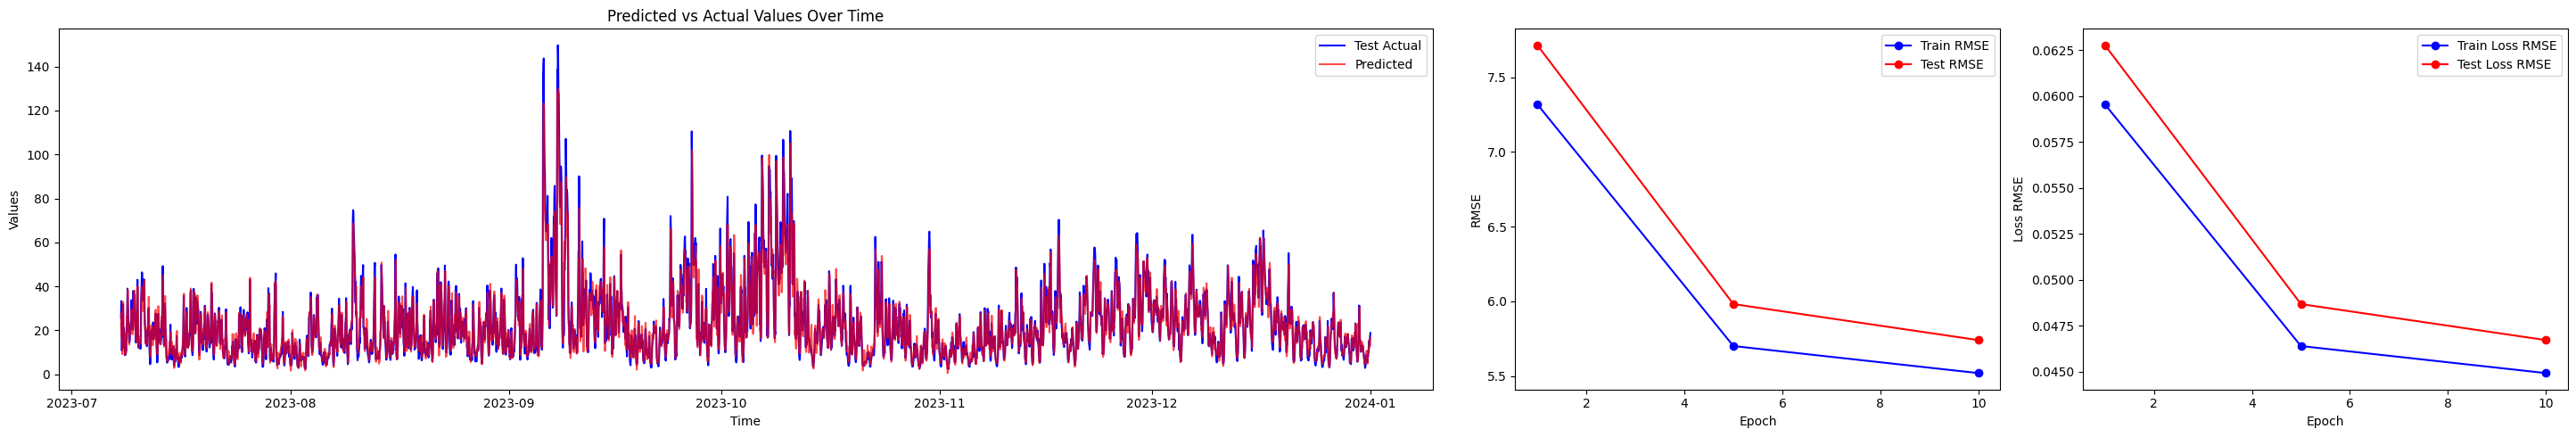

RMSE on Test Set: 5.7404


<ipython-input-7-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{key}_{i}']=data[key].shift(i)
<ipython-input-7-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{key}_{i}']=data[key].shift(i)
<ipython-input-7-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

Train:	 torch.Size([17352, 1, 216]) 	 torch.Size([17352, 1, 1])
Test:	 torch.Size([4248, 1, 216]) 	 torch.Size([4248, 1, 1])
Epoch 1 	|| train RMSE 7.7095, test RMSE 8.0951 || train loss RMSE 0.0627, test loss RMSE 0.0659
Epoch 5 	|| train RMSE 5.7164, test RMSE 6.0065 || train loss RMSE 0.0465, test loss RMSE 0.0489
Epoch 10 	|| train RMSE 5.9548, test RMSE 6.1792 || train loss RMSE 0.0485, test loss RMSE 0.0503


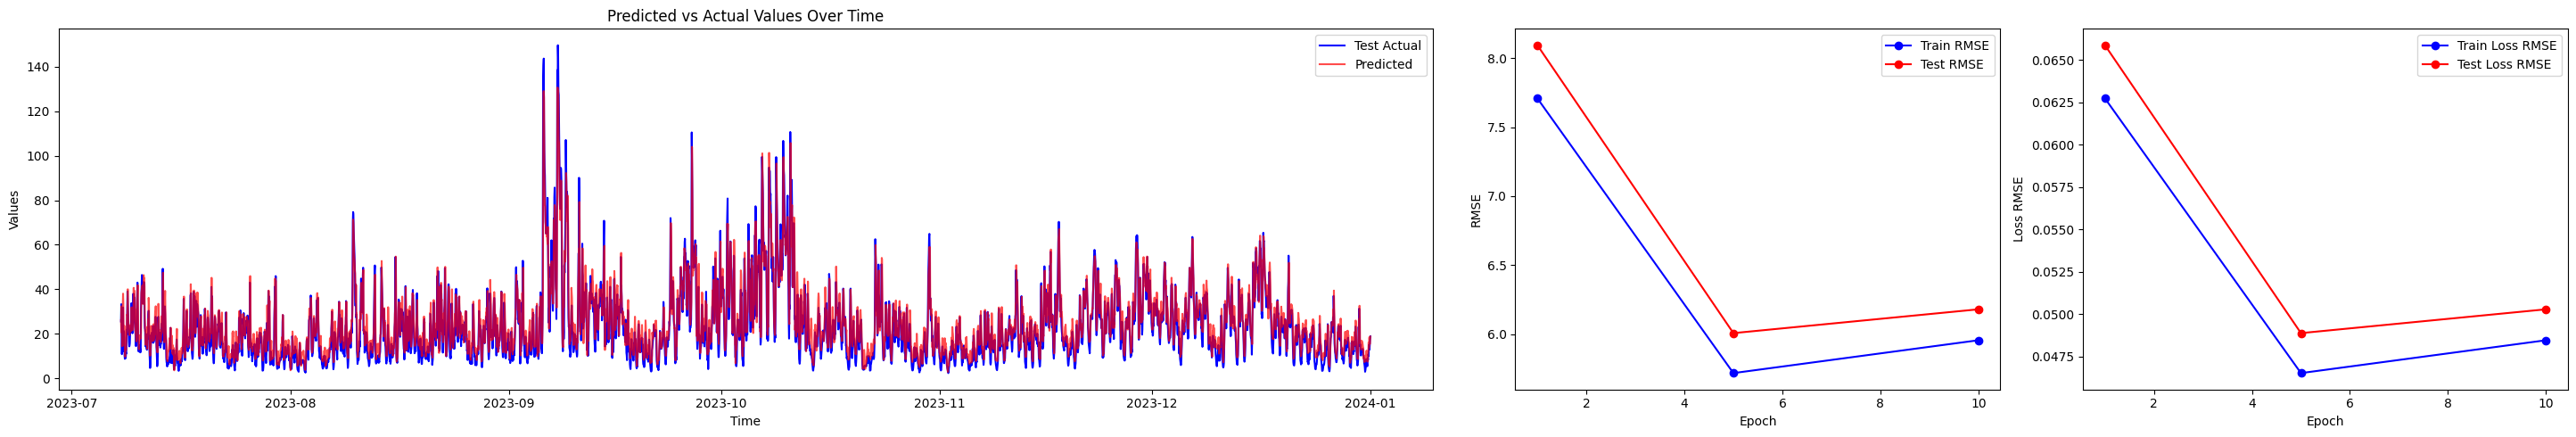

RMSE on Test Set: 6.1792


<ipython-input-7-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{key}_{i}']=data[key].shift(i)
<ipython-input-7-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{key}_{i}']=data[key].shift(i)
<ipython-input-7-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

Train:	 torch.Size([17352, 1, 312]) 	 torch.Size([17352, 1, 1])
Test:	 torch.Size([4248, 1, 312]) 	 torch.Size([4248, 1, 1])
Epoch 1 	|| train RMSE 8.7113, test RMSE 9.0515 || train loss RMSE 0.0709, test loss RMSE 0.0736
Epoch 5 	|| train RMSE 6.0990, test RMSE 6.6786 || train loss RMSE 0.0496, test loss RMSE 0.0543
Epoch 10 	|| train RMSE 5.5475, test RMSE 5.9433 || train loss RMSE 0.0451, test loss RMSE 0.0484


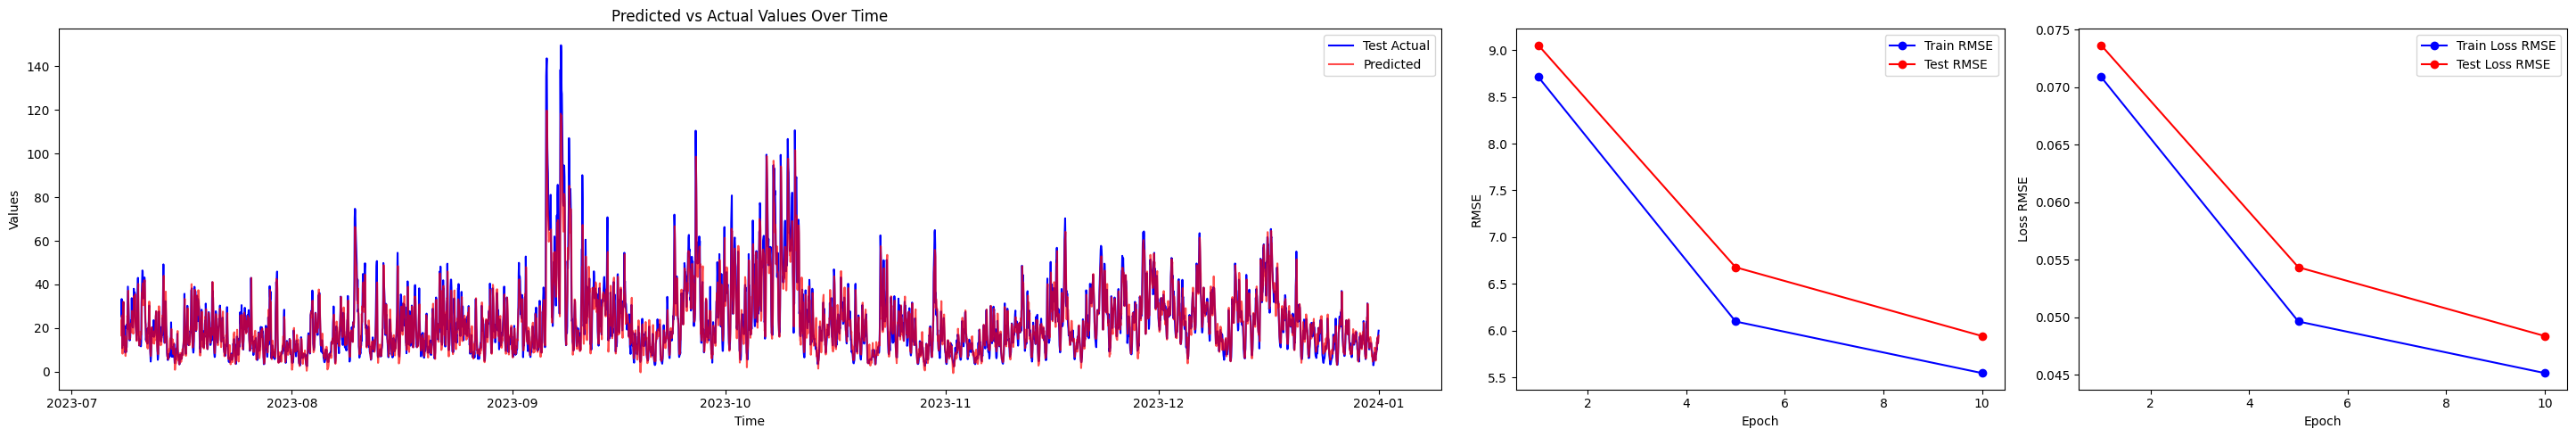

RMSE on Test Set: 5.9433


<ipython-input-7-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{key}_{i}']=data[key].shift(i)
<ipython-input-7-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{key}_{i}']=data[key].shift(i)
<ipython-input-7-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = f

Train:	 torch.Size([17352, 1, 504]) 	 torch.Size([17352, 1, 1])
Test:	 torch.Size([4248, 1, 504]) 	 torch.Size([4248, 1, 1])
Epoch 1 	|| train RMSE 9.7901, test RMSE 10.5195 || train loss RMSE 0.0797, test loss RMSE 0.0856
Epoch 5 	|| train RMSE 6.3357, test RMSE 6.7250 || train loss RMSE 0.0516, test loss RMSE 0.0547
Epoch 10 	|| train RMSE 6.2093, test RMSE 6.8271 || train loss RMSE 0.0505, test loss RMSE 0.0555


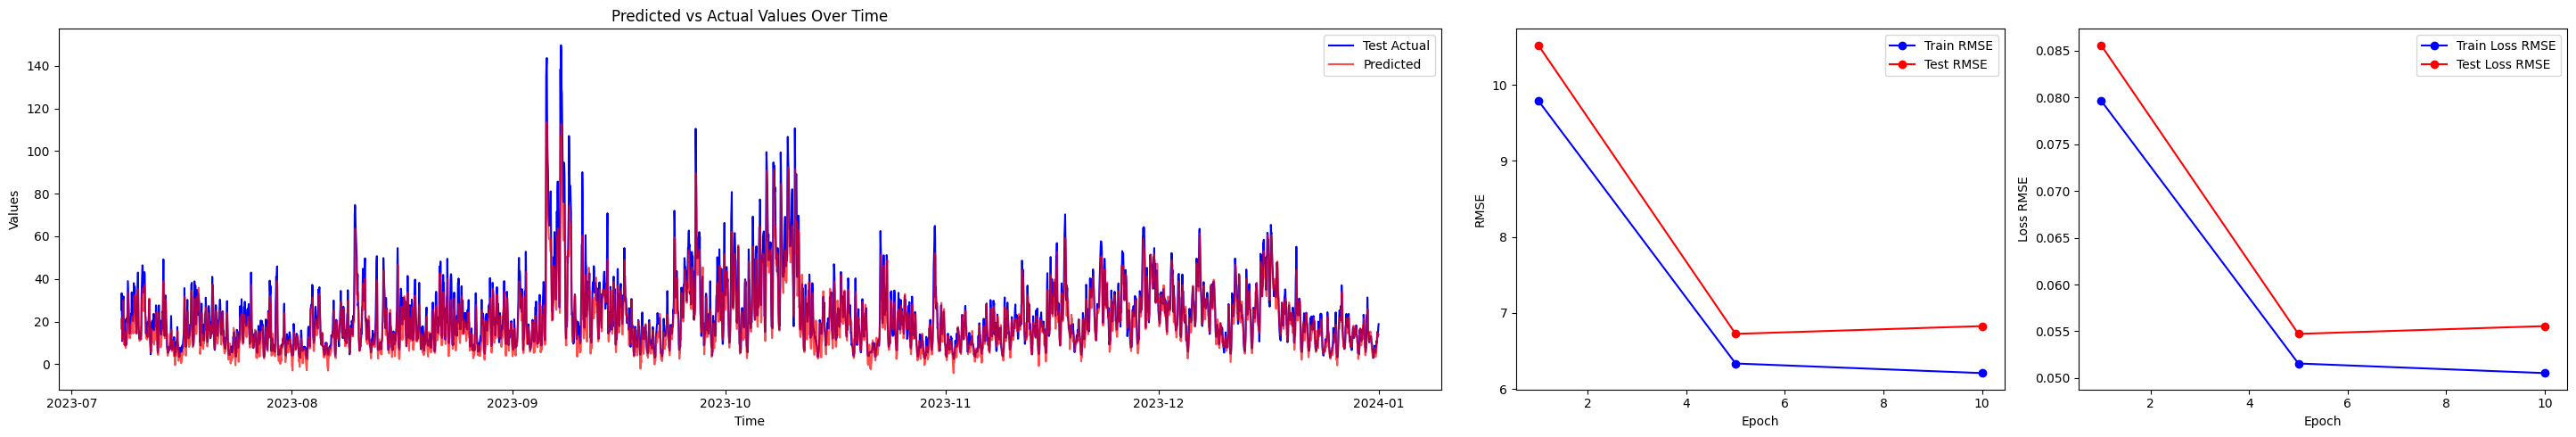

RMSE on Test Set: 6.8271


In [ ]:
# Set a seed for reproducibility
torch.manual_seed(42)

stats=[]
times=[]

for exog_lookback in [1, 12, 24, 72, 168]:
  start_time=time.time()
  lookback_dict={**{'no2':lookback, 'wind':exog_lookback, 'temp':exog_lookback}}
  train, test, scalerx, scalery, X_train, y_train, X_test, y_test = get_data(file_train,file_test, lookback_dict)
  input_size = int(X_train.size()[-1])

  m,s,t=train_rnn(X_train, y_train, X_test, y_test, scalery,
                              model_type,
                              input_size, hidden_nodes, num_layers,
                              dropout_prob=dropout_prob,
                              n_epochs=n_epochs,
                              out_every=out_every,
                              batch_size=batch_size,
                              var_y=var_y,
                              savemodel=False#True,
                  # suffix='univar-best-model'
                              )
  stats.append(s.assign(exog_lookback=exog_lookback))
  times.append(time.time()-start_time)

In [ ]:
stats=pd.concat(stats)
stats

,epoch,train_rmse,test_rmse,train_loss_rmse,test_loss_rmse,exog_lookback
0,1.0,8.380488,8.757083,0.068189,0.071254,1
1,5.0,5.861545,6.154716,0.047694,0.050079,1
2,10.0,5.643438,5.879777,0.045919,0.047842,1
0,1.0,7.317924,7.714181,0.059544,0.062768,12
1,5.0,5.700656,5.981495,0.046385,0.048670,12
2,10.0,5.519580,5.740437,0.044911,0.046708,12
0,1.0,7.709472,8.095099,0.062730,0.065867,24
1,5.0,5.716449,6.006471,0.046513,0.048873,24
2,10.0,5.954759,6.179182,0.048452,0.050278,24
0,1.0,8.711296,9.051479,0.070881,0.073649,72


In [ ]:
stats.to_csv('results/rnn_multivar_weather.csv', index=False)

In [ ]:
times

[5.878112316131592,
 7.802940607070923,
 8.25058650970459,
 6.439693212509155,
 8.669806957244873]

,epoch,train_rmse,test_rmse,train_loss_rmse,test_loss_rmse,exog_lookback
2,10.0,5.643438,5.879777,0.045919,0.047842,1
2,10.0,5.519580,5.740437,0.044911,0.046708,12
2,10.0,5.954759,6.179182,0.048452,0.050278,24
2,10.0,5.547518,5.943314,0.045138,0.048359,72
2,10.0,6.209328,6.827081,0.050523,0.055550,168


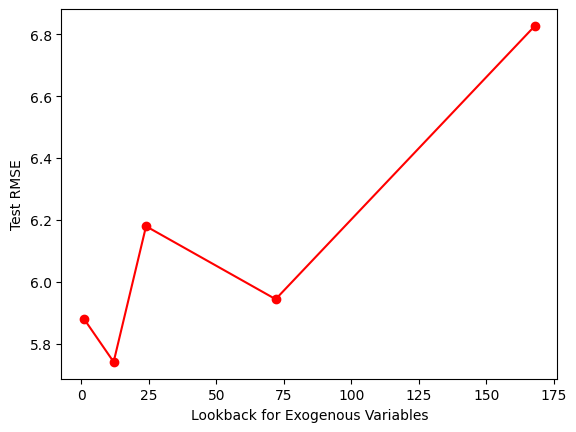

In [ ]:
df=stats.query('epoch==10')
display(df)
plt.plot(df.exog_lookback, df.test_rmse, 'ro-')
plt.xlabel('Lookback for Exogenous Variables')
plt.ylabel('Test RMSE')
plt.show()

## Add time variables

In [ ]:
# Set a seed for reproducibility
torch.manual_seed(42)

stats=[]
times=[]

for exog_lookback in [1, 12, 24, 72, 168]:
  start_time=time.time()
  lookback_dict={**{'no2':lookback},
                **{i:exog_lookback for i in cols_specific_hday+cols_month+cols_weekday+cols_day+cols_week+cols_hour}
                }
  train, test, scalerx, scalery, X_train, y_train, X_test, y_test = get_data(file_train,file_test, lookback_dict)
  input_size = int(X_train.size()[-1])

  m,s,t=train_rnn(X_train, y_train, X_test, y_test, scalery,
                              model_type,
                              input_size, hidden_nodes, num_layers,
                              dropout_prob=dropout_prob,
                              n_epochs=n_epochs,
                              out_every=out_every,
                              batch_size=batch_size,
                              var_y=var_y,
                              savemodel=False#True,
                  # suffix='univar-best-model'
                              )
  stats.append(s.assign(exog_lookback=exog_lookback))
  times.append(time.time()-start_time)

stats=pd.concat(stats)
stats.to_csv('results/rnn_multivar_datevars.csv', index=False)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
times

NameError: name 'times' is not defined

In [ ]:
df=stats.query('epoch==10')
display(df)
plt.plot(df.exog_lookback, df.test_rmse, 'ro-')
plt.xlabel('Lookback for Exogenous Variables')
plt.ylabel('Test RMSE')
plt.show()

# BEST RNN MODEL

In [ ]:
file_train = 'data/train_val_imputed.csv'
file_test = 'data/test.csv'

# Define hyperparameters of best model
top_model={'lookback': 168,
          'model_type': 'dropout-once',
          'num_layers': 1,
          'hidden_nodes': 100,
          'batch_size': 128,
          'lr': 0.0001,
          'dropout_prob': 0.0}

# Fixed
out_every = 5
n_epochs = 10

for k in top_model.keys():
  globals()[k]=top_model[k]

<ipython-input-11-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{key}_{i}']=data[key].shift(i)
<ipython-input-11-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{key}_{i}']=data[key].shift(i)
<ipython-input-11-7ad163af7e0e>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

Train:	 torch.Size([21768, 1, 168]) 	 torch.Size([21768, 1, 1])
Test:	 torch.Size([433, 1, 168]) 	 torch.Size([433, 1, 1])
Epoch 1 	|| train RMSE 7.0092, test RMSE 5.7980 || train loss RMSE 0.0473, test loss RMSE 0.0391
Epoch 5 	|| train RMSE 5.7289, test RMSE 4.1942 || train loss RMSE 0.0387, test loss RMSE 0.0283
Epoch 10 	|| train RMSE 7.6005, test RMSE 7.2446 || train loss RMSE 0.0513, test loss RMSE 0.0489


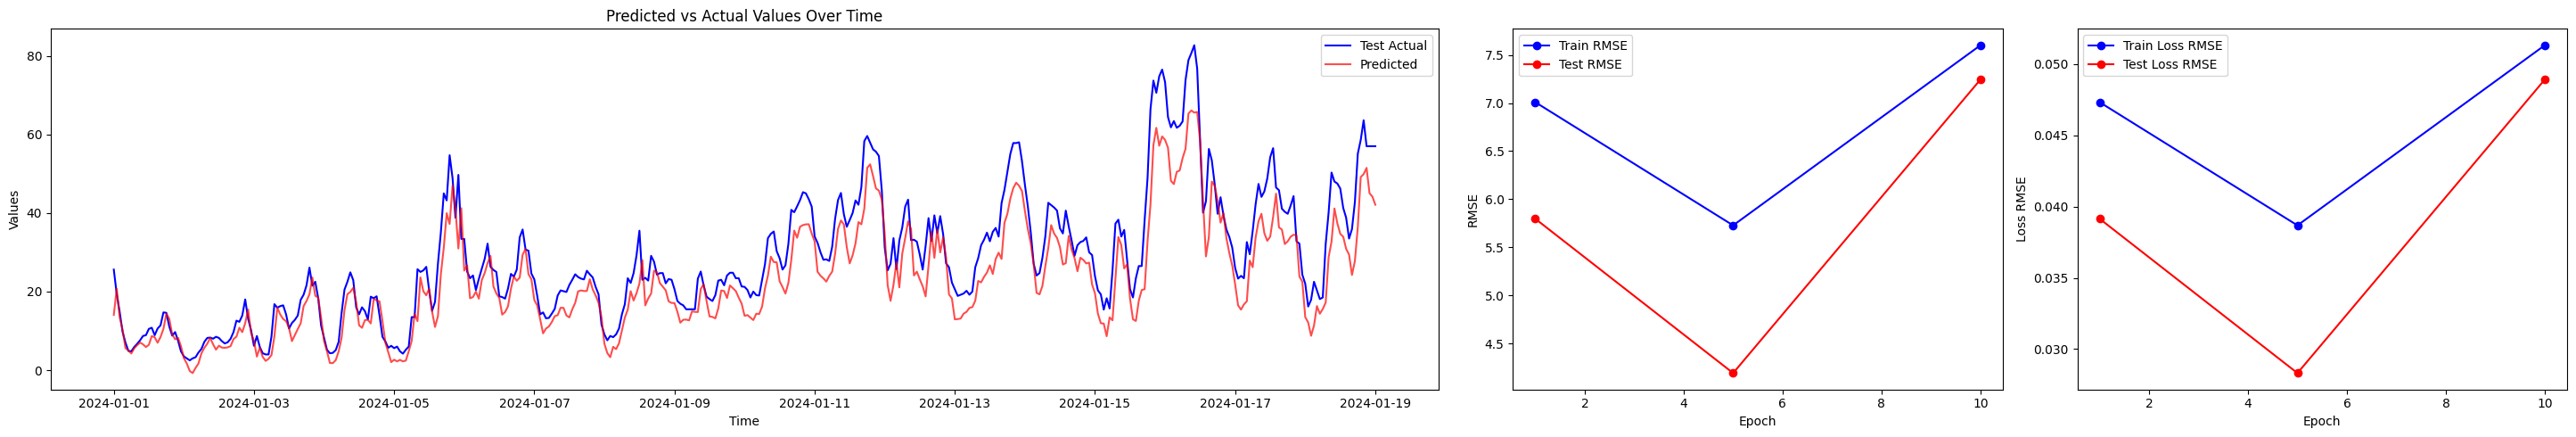

RMSE on Test Set: 7.2446
CPU times: user 9.31 s, sys: 265 ms, total: 9.58 s
Wall time: 9.58 s


In [ ]:
%%time
# Set a seed for reproducibility
torch.manual_seed(42)

lookback_dict={**{'no2':lookback}}
train, test, scalerx, scalery, X_train, y_train, X_test, y_test = get_data(file_train,file_test, lookback_dict)
input_size = int(X_train.size()[-1])

m,s,t=train_rnn(X_train, y_train, X_test, y_test, scalery,
                            model_type,
                            input_size, hidden_nodes, num_layers,
                            dropout_prob=dropout_prob,
                            n_epochs=n_epochs,
                            out_every=out_every,
                            batch_size=batch_size,
                            var_y=var_y,
                            savemodel=True,
                suffix='univar-best-model-final'
                            )